# Python scikit-learn Machine Learning Workflow 

# Outcomes

- Overview of scikit-learn for supervised machine learning
- Create training and testing data sets
- Create a workflow pipeline
    - Add a column transformer object
    - Add a feature selection object
    - Add a regression object
    - Fit a model
    - Set hyperparameters for tuning
    - Tune the model using grid search cross validation

# Setting up

In [1]:
# Import the libraries
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.model_selection import cross_val_score,\
    cross_val_predict, GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn import set_config
import matplotlib.pyplot as plt
from typing import List, Tuple
import matplotlib.axes as axes
from datetime import datetime
import datasense as ds
import pandas as pd
import numpy as np

In [2]:
# Set the global parameters
pd.options.display.max_columns = None
pd.options.display.max_rows = None
data_file_name = 'lunch_and_learn_clean.csv'
graph_name = 'predicted_versus_measured'
number_rows = 500
features = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7',
            'X8', 'X9', 'X10', 'X11', 'X12', 'X13']
target = 'Y'
mask_values = [
    ('X1', -20, 20),
    ('X2', -25, 25),
    ('X3', -5, 5),
    ('X4', -10, 10),
    ('X5', -3, 3),
    ('X6', -5, 5),
    ('X7', -13, 13),
    ('X8', -9, 15),
    ('X9', -17, 15),
    ('X10', -16, 15),
    ('X11', -16, 17),
    ('X12', -16, 17),
    ('X13', -20, 23)
]
test_size_fraction = 0.33
random_state_number = 42
set_config(display='diagram')
label_predicted = 'Predicted'
label_measured = 'Measured'
title = 'Predicted versus Measured'
figure_width_height = (8, 6)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
colour1 = '#0077bb'
colour2 = '#33bbee'

In [3]:
def main():
    data = read_data(data_file_name, number_rows)
    data = clean_data(data, mask_values)
    X, y, X_train, X_test, y_train, y_test =\
        split_data(
            data, features, target,
            test_size_fraction, random_state_number
        )
    linreg_selection, dtr_selection,\
        lasso_selection, lassocv_selection,\
        rfr_selection = feature_selection_objects()
    linreg, dtr, lasso, lassocv, rfr, xgb = regression_objects()
    pipe = workflow(features, dtr_selection, linreg, X_train, y_train, X)
    pipe.named_steps.keys()
    pipe.named_steps.columntransformer.get_params
    pipe.named_steps.selectfrommodel.get_params
    pipe.named_steps.linearregression.get_params
    # Set the hyperparameters for optimization
    # Create a dictionary
    # The dictionary key is the step name, followed by two underscores,
    # followed by the hyperparameter name
    # The dictionary value is the list of values to try for a hyperparameter
    # There are 4 x 5 x 3 x 2 = 120 combinations
    hyperparams = {}
    hyperparams['columntransformer__simpleimputer__strategy'] =\
        ['mean', 'median', 'most_frequent', 'constant']
    hyperparams['selectfrommodel__estimator'] =\
        [linreg_selection, dtr_selection, lasso_selection,
         lassocv_selection, rfr_selection]
    hyperparams['selectfrommodel__threshold'] = [None, 'mean', 'median']
    hyperparams['linearregression__normalize'] = [False, True]

    # Perform a grid search
    grid = GridSearchCV(pipe, hyperparams, cv=5)
    grid.fit(X_train, y_train);

    # Present the results
    pd.DataFrame(grid.cv_results_).sort_values('rank_test_score');

    # Access the best score
    grid.best_score_.round(3)

    # Access the best hyperparameters
    grid.best_params_

    # Create the imputer object
    imp = SimpleImputer()

    # Create the column transformer object
    ct = make_column_transformer(
         (imp, features),
         remainder='passthrough'
    )

    # Create objects to use for feature selection
    linreg_selection = LinearRegression()

    # Create the feature selection object
    selection = SelectFromModel(estimator=linreg_selection,
                                threshold='median')

    # Create objects to use for regression
    linreg = LinearRegression()

    # Create the workflow object
    pipe = make_pipeline(ct, selection, linreg)

    # Determine the linear regression model
    pipe.fit(X_train, y_train)

    # Show the selected features 
    X.columns[selection.get_support()]

    # Display the regression intercept
    pipe.named_steps.linearregression.intercept_.round(3)

    # Display the regression coefficients of the features
    pipe.named_steps.linearregression.coef_.round(3)

    # Cross-validate the updated pipeline
    cross_val_score(pipe, X_train, y_train, cv=5).mean().round(3)

    # Calculate predicted values
    predicted = cross_val_predict(pipe, X, y, cv=5)

    # Plot predicted versus measured
    plot_scatter_line(y, predicted, label_predicted, label_measured, title,
                      figure_width_height, graph_name)

    # Plot predicted versus measured
    plot_line_line(y, predicted, label_measured, label_predicted, title,
                   figure_width_height, graph_name)

In [4]:
def read_data(
    datafilename: str,
    numberrows: int
) -> pd.DataFrame:
    '''
    Read the data file into a pandas DataFrame
    '''
    df = ds.read_file(
        file_name=datafilename,
        nrows=numberrows
    )
    return df

In [5]:
def clean_data(
    df: pd.DataFrame,
    maskvalues: List[Tuple[str, float, float]]
) -> pd.DataFrame:
    '''
    Replace outliers with NaN
    '''
    for column, lowvalue, highvalue in maskvalues:
        df[column]= df[column].mask(
            (df[column] <= lowvalue) |
            (df[column] >= highvalue)
        )
    return df

In [6]:
def split_data(
    df: pd.DataFrame,
    feat: List[str],
    targ: str,
    testsize: float,
    randomstate: int
) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame,
           pd.DataFrame, pd.Series, pd.Series]:
    '''
    Split the data
    '''
    XX = df[feat]
    yy = df[targ]
    Xtrain, Xtest, ytrain, ytest =\
        train_test_split(
            XX, yy, test_size=testsize, random_state=randomstate
        )
    return (XX, yy, Xtrain, Xtest, ytrain, ytest)

In [7]:
def feature_selection_objects() -> Tuple[
    LinearRegression,
    DecisionTreeRegressor,
    Lasso,
    LassoCV,
    RandomForestRegressor
]:
    '''
    Create feature-selection objects
    '''
    linregsel = LinearRegression()
    dtrsel = DecisionTreeRegressor()
    lassosel = Lasso()
    lassocvsel = LassoCV()
    rfrsel = RandomForestRegressor()
    return (linregsel, dtrsel, lassosel, lassocvsel, rfrsel)

In [8]:
def regression_objects() -> Tuple[
    LinearRegression,
    DecisionTreeRegressor,
    Lasso,
    LassoCV,
    RandomForestRegressor,
    XGBRegressor
]:
    '''
    Create regression objects
    '''
    linregreg = LinearRegression()
    dtrreg = DecisionTreeRegressor()
    lassoreg = Lasso()
    lassocvreg = LassoCV()
    rfrreg = RandomForestRegressor()
    xgbreg = XGBRegressor()
    return (linregreg, dtrreg, lassoreg, lassocvreg, rfrreg, xgbreg)

In [9]:
def workflow(
    feat: List[str],
    select,
    regression,
    Xtrain,
    ytrain, 
    XX
):
    imp = SimpleImputer()
    ct = make_column_transformer(
         (imp, feat),
         remainder='passthrough'
    )
    selection = SelectFromModel(estimator=select,
                                threshold='median')
    pipe = make_pipeline(ct, selection, regression)
    pipe.fit(Xtrain, ytrain)
    print('selected columns:')
    print(XX.columns[selection.get_support()])
    print('regression intercept:')
    print(pipe.named_steps.linearregression.intercept_.round(3))
    print('regression coefficients')
    print(pipe.named_steps.linearregression.coef_.round(3))
    print('score:')
    print(cross_val_score(pipe, Xtrain, ytrain, cv=5).mean().round(3))
    return pipe

In [10]:
def despine(ax: axes.Axes) -> None:
    """
    Remove the top and right spines of a graph.

    Parameters
    ----------
    ax : axes.Axes

    Example
    -------
    >>> despine(ax)
    """
    for spine in 'right', 'top':
        ax.spines[spine].set_visible(False)

In [11]:
def plot_scatter_line(
    yvals: pd.Series,
    xvals: np.ndarray,
    ytext: str,
    xtext: str,
    titletext: str,
    figwh: Tuple[int, int],
    graphname: str
):
    '''
    Scatter plot of y versus x
    Line plot
    '''
    fig = plt.figure(figsize=figwh)
    ax = fig.add_subplot(111)
    ax.plot(yvals, xvals, marker='.', linestyle='', color=colour1)
    ax.plot([yvals.min(), yvals.max()], [yvals.min(), yvals.max()],
            marker=None, linestyle='-', color=colour2)
    ax.set_ylabel(ytext)
    ax.set_xlabel(xtext)
    ax.set_title(titletext)
    despine(ax)
    plt.savefig(f'{graphname}_scatter.svg')

In [12]:
def plot_line_line(
    yvals1: pd.Series,
    yvals2: np.ndarray,
    yvals1text: str,
    yvals2text: str,
    titletext: str,
    figwh: Tuple[int, int],
    graphname: str
):
    '''
    Two line plots
    '''
    fig = plt.figure(figsize=figwh)
    ax = fig.add_subplot(111)
    ax.plot(yvals1, marker='.', linestyle='-', color=colour1, label=yvals1text)
    ax.plot(yvals2, marker='.', linestyle='-', color=colour2, label=yvals2text)
    ax.set_title(titletext)
    ax.legend(frameon=False)
    despine(ax)
    plt.savefig(f'{graphname}_lines.svg')

selected columns:
Index(['X1', 'X2', 'X4', 'X6', 'X7', 'X8', 'X12'], dtype='object')
regression intercept:
69.238
regression coefficients
[ 7.083e+00 -1.310e+01 -8.955e+00  5.291e+00 -8.302e+00 -4.000e-03
  8.500e-02]
score:
0.988


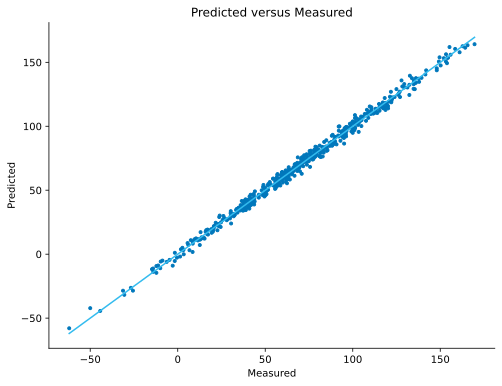

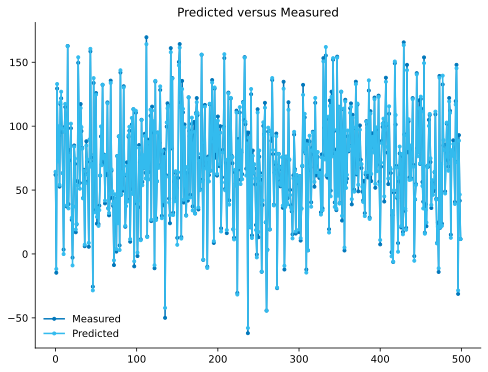

In [13]:
if __name__ == '__main__':
    main()

# References

## numpy

- [API](https://numpy.org/devdocs/reference/index.html)

## pandas

- [API](https://pandas.pydata.org/docs/reference/index.html)

- [isna](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html)

- [mask](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mask.html#pandas.DataFrame.mask)

- [options.display.max_rows, options.display.max_columns](https://pandas.pydata.org/docs/reference/api/pandas.set_option.html#pandas.set_option)

- [read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html#pandas.read_csv)

- [shape](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shape.html)

## python

- [library reference](https://docs.python.org/3/library/index.html)

- [datetime](https://docs.python.org/3/library/datetime.html)

## scikit-learn

- [API](https://scikit-learn.org/stable/modules/classes.html#)

- [compose module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.compose)

- [compose.make_column_transformer function](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html#sklearn.compose.make_column_transformer)

- [ensemble module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)

- [ensemble.RandomForestRegressor class](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)

- [feature_selection module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)

- [feature_selection.SelectFromModel class](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel)

- [feature_selection.SelectFromModel.get_support() method](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel.get_support)

- [feature_selection.SelectKBest class](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest)

- [feature_selection.f_regression scoring function](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression)

- [impute module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute)

- [impute SimpleImputer class](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer)

- [linear_model module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)

- [linear_model.Lasso class](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)

- [linear_model.LassoCV class](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV)

- [linear_model.LinearRegression class](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

- [linear models User Guide](https://scikit-learn.org/stable/modules/linear_model.html#linear-model)

- [linear regression example](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

- [model_selection module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)

- [model_selection cross_val_score function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score)

- [model_selection GridSearchCV class](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)

- [model_selection train_test_split function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split)

- [pipeline module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline)

- [pipeline.make_pipeline function](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline)

- [tree module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree)

- [tree.DecisionTreeRegressor class](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor)

## XGBoost

- [API](https://xgboost.readthedocs.io/en/latest/python/python_api.html)

- [XGBRegressor class](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)


## Machine learning

- [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics))

- [feature selection](https://en.wikipedia.org/wiki/Feature_selection)

- [hyperparameter optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization)

- [imputation](https://en.wikipedia.org/wiki/Imputation_(statistics))

- [linear regression](https://en.wikipedia.org/wiki/Linear_regression)

# Glossary

**ColumnTransformer** It is a Class in scikit-learn that applies transformers to columns in a data set.

**Cross validation** It is a model validation technique for estimating how accurately a predictive model will perform in practice. In a prediction problem, a model is usually given a dataset of known data on which training is performed (training data set) and a data set of unknown data (or first-seen data) against which the model is tested (testing data set). Cross validation tests the model's ability to predict new data that was not used in estimating it in order to identify problems such as overfitting or selection bias, and to give insight on how the model will generalize to an independent (unknown) data set. One round of cross validation involves partitioning a sample of data into complementary subsets, performing the analyis on one subset (training set) and validating the analysis on the other subset (testing set). To reduce variability in the results, multiple rounds of cross validation are performed using different partitions and the validation results are combined (averaged) over the rounds to give an estimate of the model's predictive performance.

**Data leakage** It is inadvertently including knowledge from the testing data when training a model. The model will be less reliable. This may lead to incorrect decisions when tuning hyperparameters. This may lead to overestimating how well the model will perform on new data.

**Decision tree** It is a non-parametric supervised machine learning method used for classification and regression. It uses feature importance to determine potential features that could be in the model.

**Feature** It is an independent variable that is controlled in order to cause an outcome in the dependent variable.

**Feature selection** It is the process of selecting a set of features for a model. The data set probably contains features that are redundant or irrelevant, and can be removed with little effect on a model.

**Hyperparameter** It is a value you set during the model fitting process.

**Linear regression** It is a linear approach to modeling the relationship between a target and one or more features, using linear predictor functions where unknown model parameters are estimated from the data.

**Machine Learning** Machine learning algortihms build a mathematical model on a training data subset in order to make predictions on a test data subset. Various measures are used to compare the actual and predicted data in the test data subset to estimate the performance of the model.

**Mask** It is a pandas function that replaces a value with another value, a NaN by default.

**Parameter** It is a value learned during the model fitting process.

**Pipeline** A pipeline is a series of sequential steps. The output of each step is passed to the next step. It is a scikit-learn Class that applies one or more column transformations and a final estimator. The final estimator only needs to implement fit.The purpose is to assemble several steps that can be cross-validated together while setting different hyperparameters.

**Target** It is a dependent variable that represents the outcome resulting from altering features (independent variables).

**Testing data set** It is the data set upon which we use the model and put the values of the features to predict the target in order to compare the actual target values with the predicted values in order to evaluate the performance of the model.

**Training data set** It contains known values of the target. The model learns from these data, that is, we fit a model to estimate the relationship between the target and the features.

**Transformer** It is a scikit-learn object that transforms a column. For example, it can replace NaN with the average of all values in a column.

**Workflow** It is a repeatable pattern of activity, a sequence of operations. In scikit-learn, workflow is achieved through the Pipeline class.